In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words=open('names.txt','r').read().splitlines()

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [14]:
#预测第九个字符
block_size=8

def build_dataset(words):
  X,Y=[],[]
  for w in words:
    
  
    context=[0]*block_size
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
     
        context=context[1:] + [ix]
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape)       
  return X,Y
     
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr =build_dataset(words[:n1]) #80%
Xdev,Ydev=build_dataset(words[n1:n2])#10%
Xte,Yte=build_dataset(words[n2:])#10%


torch.Size([182580, 8])
torch.Size([22767, 8])
torch.Size([22799, 8])


In [15]:
#线性
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
       self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5  #权重
       self.bias=torch.zeros(fan_out) if bias else None                   #偏差
    def __call__(self,x):
        self.out=x@self.weight
        if self.bias is not None:
          self.out+=self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#批量标准化线性层

class BatchNormld:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        self.gamma=torch.ones(dim) 
        self.beta=torch.zeros(dim) 
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        
         if self.training:
             xmean=x.mean(0,keepdim=True) #均值
             xvar=x.var(0,keepdim=True) #方差
         else:
             xmean =self.running_mean
             xvar=self.running_var
         xhat=(x-xmean)/torch.sqrt(xvar+self.eps)#数据标准化
         self.out=self.gamma*xhat+self.beta
       #更新模型运行均值和方差
         if self.training:
             with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
             return self.out
       #模型参数
    def parameters(self):
          
          return[self.gamma,self.beta]
#非线性层
class Tanh:
    
    def __call__(self,x):
      self.out=torch.tanh(x)
      return self.out
    def parameters(self):
        return[]

class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight=torch.randn((num_embeddings,embedding_dim))
    def __call__(self,IX):
        self.out=self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    
    def __init__(self,n):
        self.n=n
        
    def __call__(self,x):
        B,T,C=x.shape
        x=x.view(B,T/self.n,C*self.n)
        if x.shape[1]==1:
            x=x.squeeze(1)
            
        self.out=x
        return self.out
        
    def parameters(self):
        return[]
        
class Sequentials:
    def __init__(self,layers):
      self.layers=layers
    def __call__(self,x):
       for layer in self.layers:
        x=layer(x)
       self.out=x
       return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

#重新定义网络

n_embd=10#字符向量嵌入维度
n_hidden=200 #多层感知器中隐藏层中的数量
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size,n_embd),  generator=g)
model=Sequentials([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd*block_size,n_hidden,bias=False),BatchNormld(n_hidden),Tanh(),
    #Linear(         n_hidden,n_hidden),Tanh(),
   # Linear(         n_hidden,n_hidden),Tanh(),
   # Linear(         n_hidden,n_hidden),Tanh(),
   # Linear(         n_hidden,n_hidden),Tanh(),
    Linear(         n_hidden,vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight*=0.1
  
parameters=model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True





       
    

22097


In [16]:
ix=torch.randint(0,Xtr.shape[0],(4,))
Xb,Yb=Xtr[ix],Ytr[ix]
logits=model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 10, 21, 12,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0, 14,  1],
        [ 0, 13,  1,  3,  5, 12, 25, 14]])

In [17]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [19]:
(torch.randn(4,4,20)@torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

In [20]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [22]:
e=torch.randn(4,8,10)
explicit=torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [24]:
(e.view(4,4,20)==explicit).all()

tensor(True)

In [9]:
max_steps=200000
batch_size=32
lossa=[]
ud=[]

for i in range(max_steps):
    
    ix=torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb=Xtr[ix],Ytr[ix]
#向前传递
    #emb=C[Xb]
    #x=emb.view(emb.shape[0],-1)
    logits=model(Xb)
  
   
    loss = F.cross_entropy(logits,Yb)#损失函数
  
    for p in parameters:
       p.grad = None
    loss.backward()

    lr =0.1 if i<100000 else 0.01 #速率
    for p in parameters:
        if p.grad is not None:
           p.data += -lr * p.grad
      

    if i%10000 == 0:
      print(f':{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossa.append(loss.log10().item())   
   # with torch.no_grad():
   #   ud.append([(lr*p.grad.std()/p.data.std()).log().item() for p in parameters])


    

    

:      0/ 200000:3.2128
:  10000/ 200000:2.5782
:  20000/ 200000:2.1938
:  30000/ 200000:2.2912
:  40000/ 200000:2.2872
:  50000/ 200000:2.0369
:  60000/ 200000:2.2671
:  70000/ 200000:1.9498
:  80000/ 200000:2.0725
:  90000/ 200000:1.9501
: 100000/ 200000:2.2100
: 110000/ 200000:1.7274
: 120000/ 200000:2.1429
: 130000/ 200000:2.7751
: 140000/ 200000:1.8559
: 150000/ 200000:2.1466
: 160000/ 200000:2.1414
: 170000/ 200000:1.9989
: 180000/ 200000:1.8397
: 190000/ 200000:1.8121


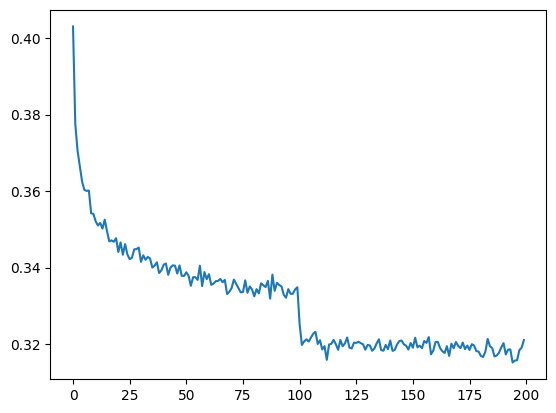

In [10]:
plt.plot(torch.tensor(lossa).view(-1,1000).mean(1))

In [ ]:
torch.arange(10).view(-1,5)

In [ ]:
for layer in model.layers:
    layer.training=False

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y ={
    'train':(Xtr,Ytr),
    'val':(Xdev,Ydev),
    'test':(Xte,Yte),
}[split]
 
  logits=model(x)
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

In [ ]:
g = torch.Generator().manual_seed(2147483647 +10)

for _ in range(20):

    out=[]
    context = [0]*block_size
    while True:
        
      emb =C[torch.tensor([context])]
      embcat=emb.view(emb.shape[0],-1)
      hpreact=embcat@W1+b1
      hpreact=bngain*(hpreact-bnmean)*(bnvar+1e-5)**-0.5+bnbias
      h=torch.tanh(hpreact)
      logits =h@W2+b2
      probs=F.softmax(logits,dim=1)
      ix = torch.multinomial(probs,num_samples=1,generator=g).item()
      context=context[1:]+[ix]
      out.append(ix)

      if ix ==0:
        break
    print(''.join(itos[i] for i in out))  